In [2]:
#Package loading
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime, date, time, timedelta

import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib import rcParams
from matplotlib.dates import DateFormatter
from matplotlib import rc
from matplotlib.dates import date2num
from IPython import display
%matplotlib inline

from scipy import stats as sps
from scipy.interpolate import interp1d

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn import linear_model
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from os import path
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (14,8)
plt.rcParams['font.size'] = 18
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
plt.rc('font', family='serif')

In [3]:
df = pd.read_csv(r"./Data/"+"hchs_quest_pa_one_hot.csv")

In [4]:
#Base for regression pipeline, this time with 'real' data extracted earlier in the notebook
#print(df.head(5))
#I've left out most of the PA columns as the are highly correlated
df_nan = df[['SleepEfficiency', 'Awakening', 'TotalSleepTime',
       'TotalWakeTime', 'SRIDay', 'SRISleep', 'mvpa_bouts_1min_decomp',
        'mvpa_bouts_10min_decomp', 'vpa_bouts_1min_decomp', 'gender', 'age', 'bmi', 'cafe', 'tea',
       'cancer', 'ssleepd', 'epworth', 'whiirs', 'insomnia_sev', 'insomnia_sev_grp_2.0',
       'insomnia_sev_grp_3.0', 'insomnia_sev_grp_4.0', 'alcohol_2.0',
       'alcohol_3.0', 'cigar_2.0', 'cigar_3.0', 'cafe_wake_1', 'cafe_wake_2',
       'cafe_wake_3', 'cafe_wake_4', 'employ_2.0', 'employ_3.0', 'employ_4.0',
       'diabetes_2.0', 'diabetes_3.0', 'persontype_1', 'persontype_2',
       'persontype_3', 'persontype_4']]

scaled_features = ['SleepEfficiency', 'Awakening', 'TotalSleepTime',
       'TotalWakeTime', 'SRIDay', 'SRISleep', 'mvpa_bouts_1min_decomp',
        'mvpa_bouts_10min_decomp', 'vpa_bouts_1min_decomp', 'age', 'bmi', 'ssleepd', 'epworth', 'whiirs']

scaler = StandardScaler()
scaler.fit(df_nan[scaled_features])
df_scaled = pd.DataFrame(scaler.transform(df_nan[scaled_features]), columns=scaled_features)
#print(df_scaled)
df_zipped = pd.concat([df_nan.drop(scaled_features,axis=1),df_scaled],axis=1).dropna()

training score: 0.435261462188585
test score:  0.45364758331904087
number of features used:  10
[0.         0.         0.02668725 0.         0.         0.01420215
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.55427392 0.11704805 0.44537287 0.23662828
 0.06747844 0.         0.         0.         0.01620292 0.12743218
 0.07639124 0.        ]
['SleepEfficiency', 'TotalWakeTime', 'SRISleep', 'ssleepd', 'Awakening', 'epworth', 'mvpa_bouts_1min_decomp', 'cafe']


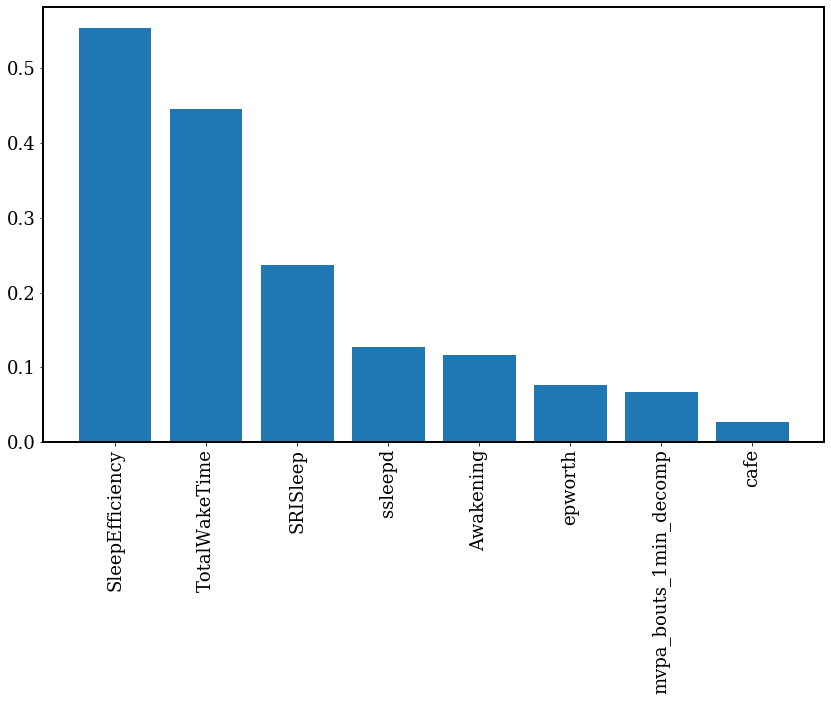

                                 OLS Regression Results                                
Dep. Variable:         TotalSleepTime   R-squared (uncentered):                   0.472
Model:                            OLS   Adj. R-squared (uncentered):              0.466
Method:                 Least Squares   F-statistic:                              77.33
Date:                Thu, 18 Jun 2020   Prob (F-statistic):                    7.32e-91
Time:                        17:37:09   Log-Likelihood:                         -735.80
No. Observations:                 701   AIC:                                      1488.
Df Residuals:                     693   BIC:                                      1524.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

In [11]:
from sklearn.linear_model import Lasso
#Regression for TST
              
col1 = 'TotalSleepTime'
X_col1 = df_zipped.drop([col1,'SRIDay'],axis=1)
y_col1 = df_zipped[col1]

X_col1 = sm.add_constant(X_col1)

#Regression with sklearn linear_model
X_train,X_test,y_train,y_test=train_test_split(X_col1,y_col1, test_size=0.3, random_state=123)
lasso = Lasso(alpha=0.05, max_iter=10e5)
model_lm_col1 = lasso.fit(X_train,y_train)
train_score=lasso.score(X_train,y_train)
test_score=lasso.score(X_test,y_test)
params = lasso.get_params()
coeff_used = np.sum(lasso.coef_!=0)

print("training score:", train_score) 
print("test score: ", test_score)
print("number of features used: ", coeff_used)

importance = np.abs(lasso.coef_)
print(importance)

# negate the coeff. to sort them in descending order
idx = (-importance).argsort()
# map index to feature list
desc_feature = [X_col1.columns[i] for i in idx]
# select the top 5 feature
top_feature = desc_feature[:8]
print(top_feature)

# summarize feature importance
#for i,v in enumerate(importance):
#    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
#plt.bar([X_col1.columns[x] for x in range(len(importance))], importance)
plt.bar(top_feature,[importance[x] for x in idx[:8]])
plt.xticks(rotation=90)
plt.show()


#Regression with sm for pvalues
# Note the difference in argument order

model_col1_sm = sm.OLS(y_train, X_train[top_feature]).fit() ## sm.OLS(output, input)
predictions = model_col1_sm.predict(X_test[top_feature])

# Print out the statistics
print(model_col1_sm.summary())


training score: 0.6826428320922446
test score:  0.5745501006455521
number of features used:  10
[0.         0.14814975 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.6724864  0.20495233 0.08116708 0.03887185
 0.00082993 0.         0.02524848 0.0233491  0.00868427 0.
 0.04001277]
['Awakening', 'TotalSleepTime', 'gender', 'SRISleep', 'whiirs', 'mvpa_bouts_1min_decomp', 'age', 'bmi']


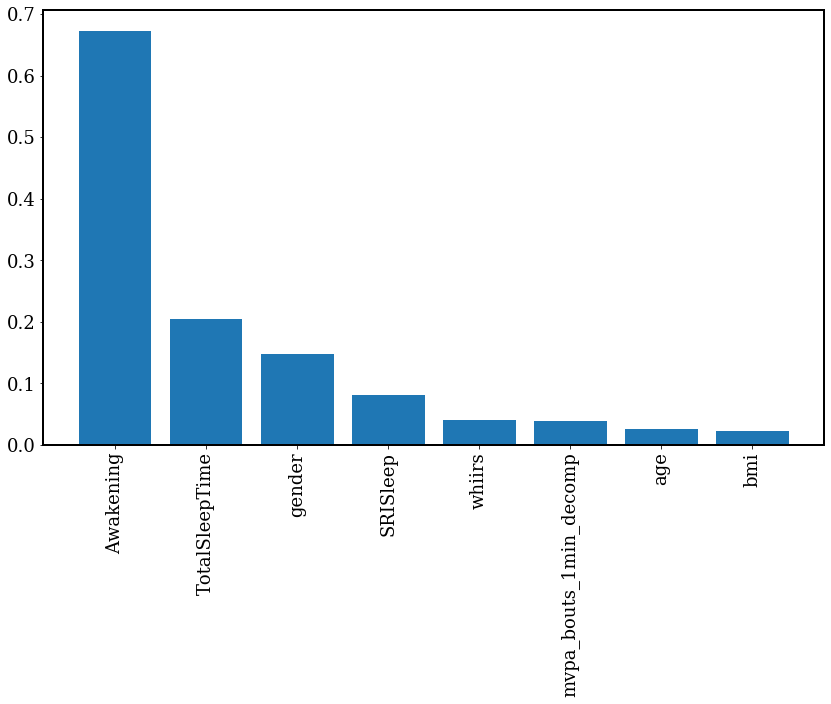

                                 OLS Regression Results                                
Dep. Variable:        SleepEfficiency   R-squared (uncentered):                   0.680
Model:                            OLS   Adj. R-squared (uncentered):              0.676
Method:                 Least Squares   F-statistic:                              184.0
Date:                Thu, 18 Jun 2020   Prob (F-statistic):                   8.32e-166
Time:                        17:29:32   Log-Likelihood:                         -579.07
No. Observations:                 701   AIC:                                      1174.
Df Residuals:                     693   BIC:                                      1211.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

In [73]:
from sklearn.linear_model import Lasso
#Regression for SEff
              
col2 = 'SleepEfficiency'
X_col2 = df_zipped.drop([col2,'SRIDay','TotalWakeTime'],axis=1)
y_col2 = df_zipped[col2]

X_col2 = sm.add_constant(X_col2)

#Regression with sklearn linear_model
X_train,X_test,y_train,y_test=train_test_split(X_col2,y_col2, test_size=0.3, random_state=123)
lasso2 = Lasso(alpha=0.02, max_iter=10e5)
model_lm_col2 = lasso2.fit(X_train,y_train)
train_score2=lasso2.score(X_train,y_train)
test_score2=lasso2.score(X_test,y_test)
params2 = lasso2.get_params()
coeff_used2 = np.sum(lasso2.coef_!=0)

print("training score:", train_score2) 
print("test score: ", test_score2)
print("number of features used: ", coeff_used2)

importance2 = np.abs(lasso2.coef_)
print(importance2)

# negate the coeff. to sort them in descending order
idx2 = (-importance2).argsort()
# map index to feature list
desc_feature2 = [X_col2.columns[i] for i in idx2]
# select the top 5 feature
top_feature2 = desc_feature2[:8]
print(top_feature2)

# summarize feature importance
#for i,v in enumerate(importance):
#    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
#plt.bar([X_col1.columns[x] for x in range(len(importance))], importance)
plt.bar(top_feature2,[importance2[x] for x in idx2[:8]])
plt.xticks(rotation=90)
plt.show()


#Regression with sm for pvalues
# Note the difference in argument order

model_col2_sm = sm.OLS(y_train, X_train[top_feature2]).fit() ## sm.OLS(output, input)
predictions = model_col2_sm.predict(X_test[top_feature2])

# Print out the statistics
print(model_col2_sm.summary())


training score: 0.3686510720768251
test score:  0.29128386070944234
number of features used:  13
Lasso(alpha=0.02, copy_X=True, fit_intercept=True, max_iter=1000000.0,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
[0.00000000e+00 7.39497386e-02 1.90461462e-02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.36021949e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.77326860e-02
 0.00000000e+00 1.71665439e-03 1.53100636e-04 0.00000000e+00
 0.00000000e+00 2.44218364e-01 1.82874723e-01 2.29430295e-01
 3.38327641e-01 0.00000000e+00 0.00000000e+00 2.28637791e-02
 0.00000000e+00 7.40815886e-02 0.00000000e+00 0.00000000e+00
 1.59809279e-02 0.00000000e+00]
['TotalSleepTime', 'persontype_4', 'Awakening', 'SleepEfficiency', 'cigar_3.0', 'age', 'gender', 'employ_4.0']


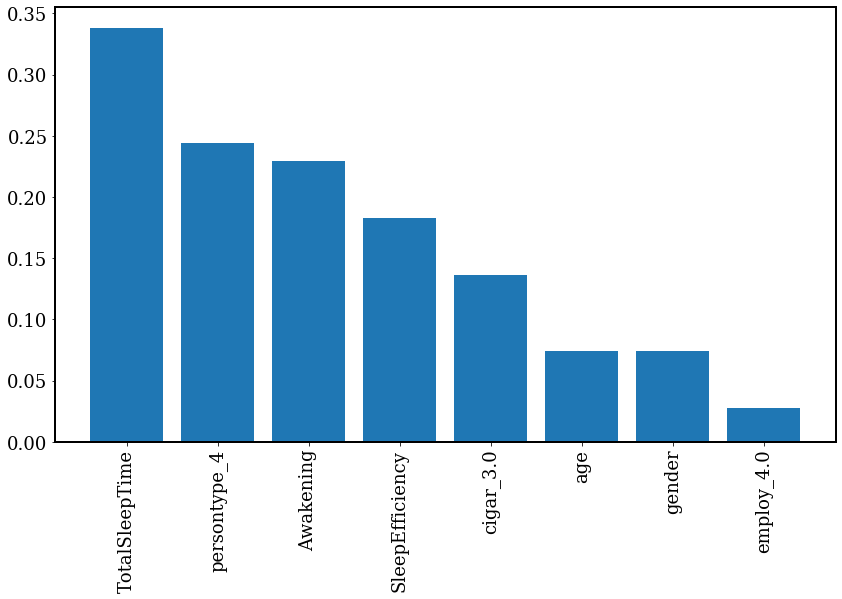

                                 OLS Regression Results                                
Dep. Variable:               SRISleep   R-squared (uncentered):                   0.366
Model:                            OLS   Adj. R-squared (uncentered):              0.359
Method:                 Least Squares   F-statistic:                              50.11
Date:                Thu, 18 Jun 2020   Prob (F-statistic):                    7.18e-64
Time:                        17:36:05   Log-Likelihood:                         -842.37
No. Observations:                 701   AIC:                                      1701.
Df Residuals:                     693   BIC:                                      1737.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

In [8]:
from sklearn.linear_model import Lasso
#Regression for SRISleep
              
col3 = 'SRISleep'
X_col3 = df_zipped.drop([col3,'SRIDay'],axis=1)
y_col3 = df_zipped[col3]

X_col3 = sm.add_constant(X_col3)

#Regression with sklearn linear_model
X_train,X_test,y_train,y_test=train_test_split(X_col3,y_col3, test_size=0.3, random_state=123)
lasso3 = Lasso(alpha=0.02, max_iter=10e5)
model_lm_col3 = lasso3.fit(X_train,y_train)
train_score3=lasso3.score(X_train,y_train)
test_score3=lasso3.score(X_test,y_test)
params3 = lasso3.get_params()
coeff_used3 = np.sum(lasso3.coef_!=0)

print("training score:", train_score3) 
print("test score: ", test_score3)
print("number of features used: ", coeff_used3)
print(model_lm_col3)

importance3 = np.abs(lasso3.coef_)
print(importance3)

# negate the coeff. to sort them in descending order
idx3 = (-importance3).argsort()
# map index to feature list
desc_feature3 = [X_col3.columns[i] for i in idx3]
# select the top 5 feature
top_feature3 = desc_feature3[:8]
print(top_feature3)

# summarize feature importance
#for i,v in enumerate(importance):
#    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
#plt.bar([X_col1.columns[x] for x in range(len(importance))], importance)
plt.bar(top_feature3,[importance3[x] for x in idx3[:8]])
plt.xticks(rotation=90)
plt.show()


#Regression with sm for pvalues
# Note the difference in argument order

model_col3_sm = sm.OLS(y_train, X_train[top_feature3]).fit() ## sm.OLS(output, input)
predictions = model_col3_sm.predict(X_test[top_feature3])

# Print out the statistics
print(model_col3_sm.summary())